# $f_{1}^{´}$
# Different candidates for different target functions?

- calculate some statistics for the characteristic values and their relation to SMCF and statistical quality parameters **(ToDo)**

In [ ]:
from scipy import rand

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity, get_fig_file_name

import luxpy as lx
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
import pandas as pd

from empir19nrm02.f1prime import py_f1PrimeGlx
from empir19nrm02.tools import plotCorrMatrixSmall
%matplotlib inline
from luxpy import _CMF, plot_spectrum_colors
from luxpy.color.utils import plot_cmfs
from luxpy.toolboxes.photbiochem import _BLH, Km_correction_factor
from luxpy.toolboxes.photbiochem import _ACTIONSPECTRA_CIES026
from luxpy.toolboxes.indvcmf import add_to_cmf_dict

from empir19nrm02 import _SPD, _RES

print('Version of luxpy:', lx.__version__)
out_dir = 'Met2'

# What about other target functions?

**$V^{'}(\lambda)$** is already included in the CMF list (cieobs='1951_20_scotopic')

To add:
- **BLH** (from the photobiochem toolbox of luxpy to the _CMF)
- **$s_{\mathrm{mel}}$** (from the photobiochem toolbox ipRGC to the _CMF)

BLH


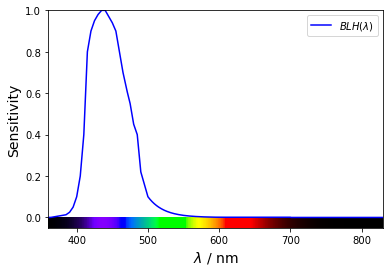

SMEL


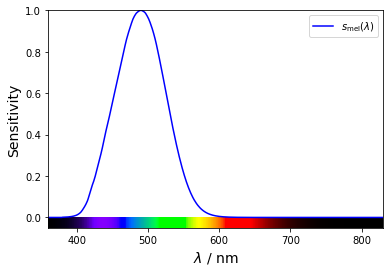

In [2]:
if 'BLH'  not in _CMF['types']:
    print( 'BLH')
    add_to_cmf_dict(bar=np.vstack((_BLH,_BLH[1],_BLH[1])), cieobs = 'BLH', K = 683, M = np.eye(3))
    plot_cmf2( name='BLH', cmf_symbols=['BLH'], cmf_colors = ['b-'],  single=True)
    save_fig( out_dir, 'BLH_function')

if 'SMEL'  not in _CMF['types']:
    print( 'SMEL')
    add_to_cmf_dict(bar=np.vstack((_ACTIONSPECTRA_CIES026[0],_ACTIONSPECTRA_CIES026[5],_ACTIONSPECTRA_CIES026[5],_ACTIONSPECTRA_CIES026[5])), cieobs = 'SMEL', K = 683*Km_correction_factor, M = np.eye(3))
    plot_cmf2( name='SMEL', cmf_symbols=['s_{\mathrm{mel}}'], cmf_colors = ['b-'],  single=True)
    save_fig( out_dir, 'SMEL_function')

# What we need to evaluated/calculate:

- Detectors --> _detectors
- Target functions --> _target_name **and** index
- Spectral distributions --> _spectra
- SMCF's evaluated for the combination of Detectors/target function and SD depending on the calibration
- Characteristic values to be evaluated for the detectors --> cValues
- Evaluation of the connection between the cValues and the SMCF values


In [3]:
def calc_cValues( detectors, target_name = '1931_2', target_index=2):
    f1pA=py_f1PrimeGlx(detectors, strObserver=target_name, iObserverOffset = target_index-1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
    f1pE=py_f1PrimeGlx(detectors, strObserver=target_name, iObserverOffset = target_index-1, strWeighting='E', iMin=0, dCutOff=0., dBandWidth=0.)
    f1pLED=py_f1PrimeGlx(detectors, strObserver=target_name, iObserverOffset = target_index-1, strWeighting='LED_B3', iMin=0, dCutOff=0., dBandWidth=0.)
    f1pAFMin=py_f1PrimeGlx(detectors, strObserver=target_name, iObserverOffset = target_index-1, strWeighting='A', iMin=1, dCutOff=0., dBandWidth=0.)
    f1pp=py_f1PrimeGlx(detectors, strObserver=target_name, iObserverOffset = target_index-1, strWeighting='E', iMin=0, dCutOff=dCutOff, dBandWidth=0.)
    f1ppR=py_f1PrimeGlx(detectors, strObserver=target_name, iObserverOffset = target_index-1, strWeighting='E', iMin=0, dCutOff=-dCutOff, dBandWidth=0.)
    f1pBW20nm=py_f1PrimeGlx(detectors, strObserver=target_name, iObserverOffset = target_index-1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=20.)

    return f1pA, f1pE, f1pLED, f1pAFMin, f1pp, f1ppR, f1pBW20nm

In [4]:
def makeLinearRegression( _xdata, _ydata):
    lr_model = LinearRegression()
    xdata = _xdata.copy()
    nonZeros =np.where(_xdata != 0)
    xdata= xdata.reshape(-1,1)
    lr_model.fit(xdata, _ydata)
    slope=lr_model.coef_[0]
    offset=lr_model.intercept_
    r_sq = lr_model.score(xdata, _ydata)

    # without the first data set (normally zero)
    smcfSlopeMax = np.zeros(xdata.shape[0])
    smcfSlopeMax[nonZeros]=_ydata[nonZeros]/_xdata[nonZeros]
    smcfSlopeQMax = np.quantile( smcfSlopeMax, 1-quantil)

    print( slope, offset, r_sq, smcfSlopeQMax)
    return slope, offset, r_sq, smcfSlopeQMax

# Sensitivity for wavelength dependent noise

In [5]:
def eval_target_noise( target, str_target, name):
    _detectorsNoise = target.copy()

    for i in range(0, target.shape[1]):
        to_add = target.copy()
        to_add[1,i] += .1
        _detectorsNoise= np.vstack((_detectorsNoise, to_add[1]))

    fig, ax1 = pyplot.subplots()
    ax1.plot(_detectorsNoise[0], _detectorsNoise[1], 'g-', label=str_target)
    ax1.plot(_detectorsNoise[0], _detectorsNoise[4], '*', label=str_target +'$ + \Delta$')
    ax1.set_xlabel(strd['xlambda'], fontsize=label_font_size)
    ax1.set_ylabel('Signal' + strd['AU'], fontsize=label_font_size)
    ax1.set_xlim([380, 500])
    ax1.set_ylim([0, 0.2])
    pyplot.legend()
    save_fig(out_dir, name + 'noiseSingle')


    nf1pA, nf1pE, nf1pLED, nf1pAFMin, nf1pp, nf1ppR, nf1pBW20nm = \
        calc_cValues(_detectorsNoise, _target_name, _target_index)

    nsubPlot = 2

    xRange = np.arange(375,780+1,5)
    fig, ax1 = pyplot.subplots()
    ax2 = ax1.twinx()

    ax1.plot(xRange[1::nsubPlot], nf1pA[1::nsubPlot], '-', label=strd['f1p'])
    ax1.plot(xRange[1::nsubPlot], nf1pE[1::nsubPlot], 'x', label=strd['f1pE'])
    ax1.plot(xRange[1::nsubPlot], nf1pLED[1::nsubPlot], '--', label=strd['f1pLED'])
    ax1.plot(xRange[1::nsubPlot], nf1pAFMin[1::nsubPlot], '<', label=strd['f1pMin'])
    ax1.plot(xRange[1::nsubPlot], nf1ppR[1::nsubPlot], '>', label=strd['f1ppR'])
    ax1.plot(xRange[1::nsubPlot], nf1pBW20nm[1::nsubPlot], '2', label=strd['f1pBW'])
    ax2.plot(xRange[1::nsubPlot], nf1pp[1::nsubPlot], '1', label=strd['f1pp'])

    ax1.set_xlabel(strd['xlambda'], fontsize=label_font_size)
    ax1.set_ylabel(strd['f1p'] + ',' + strd['f1pE'] + ',' +  strd['f1pMin'] + ',' +  strd['f1ppR'] + ',' +  strd['f1pBW'], fontsize=label_font_size)
    ax2.set_ylabel(strd['f1pp'], fontsize=label_font_size)
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    pyplot.legend(lines, labels, bbox_to_anchor=(0.0, -0.3, 1, 0), loc='lower left',
               ncol=7, mode="expand", borderaxespad=0.)
    save_fig(out_dir, name + 'noiseEval')

# Sensitivity for correlated wavelength shifts

In [6]:
def eval_target_shift( target, str_target, name):
    _detectorsShift = target.copy()

    shift2min = 0
    shift2max = 5
    shift_steps = 0.1
    shift_range = np.arange(shift2min, shift2max+2*shift_steps, shift_steps)

    for i in shift_range:
        wl_current = _detectors[0]+i
        target_moved = np.vstack((wl_current, target[1]))
        target_interpolated = lx.cie_interp(target_moved, target[0], negative_values_allowed=True, kind='linear')
        _detectorsShift = np.vstack((_detectorsShift, target_interpolated[1]))

    detectors_shift_number = _detectorsShift.shape[0]
    pyplot.plot(_detectorsShift[0,:], _detectorsShift[2,:], 'r-', label='shift ' + str(shift2min)+ ' nm')
    pyplot.plot(_detectorsShift[0,:], _detectorsShift[int((detectors_shift_number-1)/2),:], 'g-', label=str_target)
    pyplot.plot(_detectorsShift[0,:], _detectorsShift[detectors_shift_number-1,:], 'b-', label='shift +' + str(shift2max)+ ' nm')
    pyplot.xlabel(strd['xlambda'], fontsize=label_font_size)
    pyplot.ylabel(str_target + ',' + strd['srelLambda'], fontsize=label_font_size)
    pyplot.legend()
    save_fig(out_dir, name + 'ShiftsSingle')

    sf1pA, sf1pE, sf1pLED, sf1pAFMin, sf1pp, sf1ppR, sf1pBW20nm = \
        calc_cValues(_detectorsShift, _target_name, _target_index)

    fig, ax1 = pyplot.subplots()
    ax2 = ax1.twinx()

    xRange = shift_range
    subPlot = 5
    ax1.plot(xRange[1::subPlot], sf1pA[1::subPlot], '-', label=strd['f1p'])
    ax1.plot(xRange[1::subPlot], sf1pE[1::subPlot], 'x', label=strd['f1pE'])
    ax1.plot(xRange[1::subPlot], sf1pLED[1::subPlot], '--', label=strd['f1pLED'])
    ax1.plot(xRange[1::subPlot], sf1pAFMin[1::subPlot], '<', label=strd['f1pMin'])
    ax1.plot(xRange[1::subPlot], sf1ppR[1::subPlot], '>', label=strd['f1ppR'])
    ax1.plot(xRange[1::subPlot], sf1pBW20nm[1::subPlot], '2', label=strd['f1pBW'])
    ax2.plot(xRange[1::subPlot], sf1pp[1::subPlot], '1', label=strd['f1pp'])

    ax1.set_xlabel('$\Delta\lambda$ / nm', fontsize=label_font_size)
    ax1.set_ylabel(strd['f1p'] + ',' + strd['f1pE'] + ',' +  strd['f1pMin'] + ',' +  strd['f1ppR'] + ',' +  strd['f1pBW'], fontsize=label_font_size)
    ax2.set_ylabel(strd['f1pp'], fontsize=label_font_size)
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    pyplot.legend(lines, labels, bbox_to_anchor=(0.0, -0.2, 1, 0), loc='upper left',
               ncol=7, mode="expand", borderaxespad=0.)
    save_fig(out_dir, name + 'ShiftsEval')
    return  np.array([0, sf1pA[-1],sf1pE[-1],sf1pLED[-1],sf1pAFMin[-1],sf1ppR[-1],sf1pBW20nm[-1]])/float(shift2max)

In [7]:
def display_spectra( spd, _spectra, out_dir=None):
    # plot the mean value with some statistical data
    s_number = _spectra.shape[0]-1
    print( s_number)
    for i in range(2,s_number,int(s_number/10)):
        print(i)
        pyplot.plot(_spectra[0], _spectra[i]/np.max(_spectra[i]))
    pyplot.ylabel(strd['SDLambda'],fontsize=label_font_size)
    pyplot.xlabel(strd['xlambda'],fontsize=label_font_size)

    if out_dir is not None:
        save_fig( out_dir, spd+'_SPDSamples')

    # Horseshoo missing
    if out_dir is not None:
        save_fig( out_dir, spd+'_xy')

In [8]:
_DETECTOR_TYPES = ['VLDetectors','XDetectors','YDetectors','ZDetectors','BLHDetectors','VSDetectors','SMELDetectors']
_TARGET_NAMES = ['1931_2','1931_2','1931_2','1931_2','BLH','VS','SMEL']
_TARGET_INDEX = [2,1,2,3,2,2,2]

strNames=['', 'f1p', 'f1pE', 'f1pLED', 'f1pMin', 'f1ppR', 'f1pBW20nm']
f1pTable = pd.DataFrame()

for i, detector_type in enumerate(_DETECTOR_TYPES): # store all in single nested dict
#for i in range(0,2):
    _name = _DETECTOR_TYPES[i]
    _target_name = _TARGET_NAMES[i]
    _target_index = _TARGET_INDEX[i]
    S_C = 'LED_L41' # 'A'
    spd = 'PHOTOLED' # 'BB, 'PHOTOLED', 'MONOLED'

    str_target = ''
    if _target_name == '1931_2':
        if _target_index == 1:
            str_target = '$X(\lambda)$'
        elif _target_index == 2:
            str_target = '$V(\lambda)$'
        elif _target_index == 3:
            str_target = '$Z(\lambda)$'
    else:
        if _target_name == 'BLH':
            str_target = '$BLH(\lambda)$'
        if _target_name == 'VS':
            str_target = '$V^{´}(\lambda)$'
            _target_name = '1951_20_scotopic'
        if _target_name == 'SMEL':
            str_target = '$s_{\mathrm{mel}}(\lambda)$'

    _detectors=_RES[_name]['S']['data'].copy()
    display_responsivity(_name, _detectors, cieobs=_target_name, s_target_index=_target_index, out_dir=out_dir)

    _spectra=_SPD[spd]['S']['data'].copy()
    display_spectra( spd, _spectra, out_dir=out_dir)

    _SMCF=np.abs(1.-lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(
        _spectra, _detectors, S_C=S_C, cieobs=_target_name))

    c_f1pA, c_f1pE, c_f1pLED, c_f1pAFMin, c_f1pp, c_f1ppR, c_f1pBW20nm = calc_cValues(_detectors, _target_name, _target_index)

    qPlus=np.quantile( _SMCF, 1-quantil, axis=0)

    # Correlations between the index values

    # Combine the results in a vector
    f1pEval = np.vstack(( c_f1pA, c_f1pE, c_f1pLED, c_f1pAFMin, c_f1pp, c_f1ppR, c_f1pBW20nm, qPlus))
    f1pEvalCorr = np.corrcoef(f1pEval)
    x_label_list = [ strd['f1p'], strd['f1pE'], strd['f1pLED'], strd['f1pMin'], strd['f1pp'], strd['f1ppR'], strd['f1pBW'], strd['q_plus_a']]
    plotCorrMatrixSmall(f1pEvalCorr, x_label_list, title=None, fileName=None, with_values=True)
    save_fig(out_dir, _name + 'corr')

    print( strd['f1p'])
    s_f1pA=makeLinearRegression( c_f1pA, qPlus)
    print( strd['f1pE'])
    s_f1pE=makeLinearRegression( c_f1pE, qPlus)
    print( strd['f1pLED'])
    s_f1pLED=makeLinearRegression( c_f1pLED, qPlus)
    print( strd['f1pMin'])
    s_f1pAFMin=makeLinearRegression( c_f1pAFMin, qPlus)
    print( strd['f1ppR'])
    s_f1ppR=makeLinearRegression( c_f1ppR, qPlus)
    print( strd['f1pBW'])
    s_f1pBW20nm=makeLinearRegression( c_f1pBW20nm, qPlus)
    data=[s_f1pA, s_f1pA, s_f1pE, s_f1pLED, s_f1pAFMin, s_f1ppR, s_f1pBW20nm]

    fig, ax = pyplot.subplots()
    ax.set_xlabel('cValue', fontsize=label_font_size)
    ax.set_ylabel(strd['q_plus_a'], fontsize=label_font_size)
    ax.plot( c_f1pA, qPlus, 'r1', label=strd['f1p'])
    ax.plot( c_f1pA, s_f1pA[0]*c_f1pA + s_f1pA[1], 'r-', label=strd['f1p'])
    ax.plot( c_f1pE, qPlus, 'g2', label=strd['f1pE'])
    ax.plot( c_f1pE, s_f1pE[0]*c_f1pE + s_f1pE[1], 'g-', label=strd['f1pE'])
    ax.plot( c_f1pLED, qPlus, 'b3', label=strd['f1pLED'])
    ax.plot( c_f1pLED,s_f1pLED[0]* c_f1pLED+s_f1pLED[1], 'b-', label=strd['f1pLED'])
    ax.plot( c_f1pAFMin, qPlus, 'r4', label=strd['f1pMin'])
    ax.plot( c_f1ppR, qPlus, 'g4', label=strd['f1ppR'])
    ax.plot( c_f1ppR, s_f1ppR[0]*c_f1ppR+s_f1ppR[1], 'g-', label=strd['f1ppR'])
    ax.plot( c_f1pBW20nm, qPlus, 'b4', label=strd['f1pBW'])
    ax.legend()
    save_fig(out_dir, _name + 'cValueReg')

    # target funciton in the right resolution
    target = get_target(cieobs=_target_name, target_index=_target_index, wl_new= _detectors[0])

    # no numbers generated from this investigation
    eval_target_noise( target, str_target, _name)

    eval_shift=eval_target_shift( target, str_target, _name)

    for i in range(1,7):
        v_m_current = data[i]
        df = pd.DataFrame( { \
            'N': [i], \
            'Target': str_target,
            'Name': strNames[i], \
            'm_q95': v_m_current[0],
            'n_q95': v_m_current[1], \
            'r_sq_q95': v_m_current[2],
            'smcfSlopeQMax': v_m_current[3],
            'shift [1/nm]': eval_shift[i]} )
        f1pTable = f1pTable.append( df)

    print( f1pTable)

f1pTable.to_csv(get_fig_file_name(out_dir, 'f1pTable', table=True), sep=';',  decimal=",")



VLDetectors


KeyError: 'LED_L41'

In [ ]:
def makeTable( spectraLoc, filename, use_SMCFLED=True):
    #[_, v_m_Dataf1p,v_m_Dataf1pE, v_m_Dataf1pLED, v_m_Dataf1pAFMin, v_m_Dataf1ppR, v_m_Dataf1pBW20nm]= \
    data = calc_data_from_spectra_detectors( vldetectors, spectraLoc, eins_minus=True, r_sq_calc=True, use_SMCFLED=use_SMCFLED)

    strNames=['', 'f1p', 'f1pE', 'f1pLED', 'f1pMin', 'f1ppR', 'f1pBW20nm']
    f1pTable = pd.DataFrame()
    for i in range(1,7):
        v_m_current = data[i]
        #strName = 'f1p'
        df = pd.DataFrame( { \
            'N': [i], \
            'Name': strNames[i], \
            'm_mean': v_m_current[0], 'm_mean_r_sq': v_m_current[1], \
            'm_sigma': v_m_current[2], 'm_sigma_r_sq': v_m_current[3], \
            'm_qMax': v_m_current[4], 'm_qMax_r_sq': v_m_current[5], \
            'smcfSlopeQMax': v_m_current[6] } )
        f1pTable = f1pTable.append( df)

    print( f1pTable)
    f1pTable.to_csv(get_fig_file_name(filename, table=True), sep=';',  decimal=",")